# Qiskit for QKD

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np

### Proving qubits cant be intercepted

If Alice prepares a qubit in state |+> (0 in x basis) then Bob will definitely measure 0

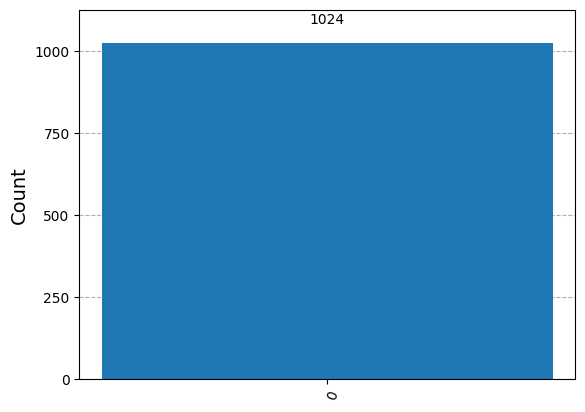

In [2]:
# A preps qubit
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.barrier()

# A sends qubit to B and B measures it in the X basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
qc.draw()
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())


Now if Eve tries to intercept the qubit, the interference becomes obvious

┌───┐┌─┐ ░ ┌───┐┌─┐
  q: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c: 1/══════╩══════════╩═
           0          0

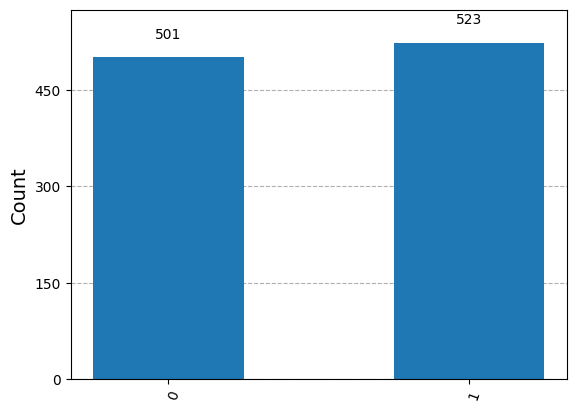

In [3]:
# A preps qubit in state |+>
qc = QuantumCircuit(1,1)
qc.h(0)

# A tries to send the qubit to B but E intercepts it
qc.measure(0, 0)
qc.barrier()

# E then passes this on to B who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

Bob now has a 50% chance of measuring 1, so he knows the message has been intercepted so he can discard it

### QKD 
#### Quantum Transmission
Alice generates random sequence of bits and encodes it using a random sequence of bases

In [17]:
np.random.seed(seed=0)
n = 100 # length of sequence to generate

aliceBits = randint(2, size=n)
print(aliceBits)
aliceBases = randint(2, size=n) # 0 represents Z basis and 1 represents X basis
print(aliceBases)

def encodeMessage(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

message = encodeMessage(aliceBits, aliceBases)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]
[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [18]:
print('bit = %i' % aliceBits[0])
print('basis = %i' % aliceBases[0])
message[0].draw() #shown to be in the state |+>

bit = 0
basis = 1


┌───┐ ░ 
  q: ┤ H ├─░─
     └───┘ ░ 
c: 1/════════

The message of qubits are then sent over a quantum channel and Bob chooses a random sequence of bases to measure them in. He keeps these results private but the channel used to communicate the message could have been compromised (we'll see this later)

In [6]:
def measureMessage(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        result = aer_sim.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

bobBases = randint(2, size=n)
bobResults = measureMessage(message, bobBases)

In [7]:
print(bobResults)
message[0].draw() # shows the bit has been measured

[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]


┌───┐ ░ ┌───┐┌─┐
  q: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

#### Post-Processing
Alice and Bob then share which bases they each used and discard the bits measured in different bases, producing the key with the remaining bits. This information is done across a classical channel, and so it could be intercepted by Eve.

In [8]:
def removeDifferences(aBases, bBases, bits):
    sameBits = []
    for q in range(n):
        if aBases[q] == bBases[q]:
            sameBits.append(int(bits[q]))
    return sameBits
    
aliceKey = removeDifferences(aliceBases, bobBases, aliceBits)
bobKey = removeDifferences(aliceBases, bobBases, bobResults)
print(aliceKey)
print(bobKey)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


The last step is to choose a sample of bits to share and compare, so that Alice and Bob can ensure they have the same key.

In [9]:
def sampleBits(bits, selection):
    sample = []
    for i in selection:
        i = np.mod(i, len(bits)) # np.mod ensures i is in the range required
        sample.append(bits.pop(i)) # removes it from bits and appends to sample
    return sample
    
sampleSize = 15
bitSelection = randint(n, size=sampleSize)

bobSample = sampleBits(bobKey, bitSelection)
print("  bob_sample = " + str(bobSample))
aliceSample = sampleBits(aliceKey, bitSelection)
print("alice_sample = "+ str(aliceSample))

if bobSample == aliceSample:
    print("Yay! Keys match! key length = %i" % len(aliceKey))
else:
    print("Uh Oh! The keys don't match! try again")

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Yay! Keys match! key length = 33


### Interception
Now, if the channel over which Alice and Bob share information is compromised and Eve intercepts all the information, can she find the key?

In [10]:
np.random.seed(seed=3)

# A creates her random sequence of bits and bases and encodes them
aliceBits = randint(2, size=n)
aliceBases = randint(2, size=n)
message = encodeMessage(aliceBits, aliceBases)

# Interception!! E measures the qubits with her own bases sent across the channel
eveBases = randint(2, size=n)
interceptedMessage = measureMessage(message, eveBases)

# B then measures the qubits with his own bases
bobBases = randint(2, size=n)
bobResults = measureMessage(message, bobBases)

# A and B compare bases and discard all the bits measured using different bases
bobKey = removeDifferences(aliceBases, bobBases, bobResults)
aliceKey = removeDifferences(aliceBases, bobBases, aliceBits)

# Now when A and B sample their respective keys, they can notice something has gone wrong
sampleSize = 15
bitSelection = randint(n, size=sampleSize)
bobSample = sampleBits(bobKey, bitSelection)
print("  bob_sample = " + str(bobSample))
aliceSample = sampleBits(aliceKey, bitSelection)
print("alice_sample = "+ str(aliceSample))

if bobSample == aliceSample:
    print("Yay! Keys match! key length = %i" % len(aliceKey))
else:
    print("Uh Oh! The keys don't match! Eve's interference was detected")

  bob_sample = [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Uh Oh! The keys don't match! Eve's interference was detected


Although Alice and Bob have detected the difference in their keys using the sample, they have no way of knowing what caused this so they are forced to start over. It could have been due to noise in the channel or other factors. 
As Eve measures all the qubits passed along the channel, we can calculate how likely it is that Eve's interception will be detected. For each qubit that remains after Alice and discard the bits they measured using different bases, Eve has a 50% chance of guessing the basis correct and if she gets it wrong, there is a 50% chance Bob still reads it right. So each bit has a 0.75 probability of matching and given a sample of size 15 (as above), there is a 0.75<sup>15</sup> = 1.3% chance of Eve's interception being undetected. This probability decreases exponentially with sample size and so ca be reduced significantly.

### Other Protocols

This protocol is called BB84 and was proposed by Charles Bennett and Gilles Brassard. It consists of two channels - the classical and quantum - and uses the rectilinear ⊕ = (|0>, |1>) and diagonal ⊗ = (|+>, |->) polarisation basis (these are mutually unbiased, which is why when Bob measures with the wrong  basis, that information is discarded because it is completely random and unpredictable).

#### B92

Another protocol is B92, also presented by Charles Bennett several years later, which only uses two states of polarisation (not 4 like BB84). Similar to BB84, B92 uses polarised photons, communicates using a public classical channel and a quantum channel, and is split into two phases: the quantum transmission, and the classical post-processing.

In B92's first phase, Alice chooses a sequence of bits, and encodes each 0 as |0> and each 1 as |+>. Bob also chooses a sequence of bits and uses this to produce a sequence of bases: ⊕ for 0 and ⊗ for 1. Alice then sends her encoded bits across the quantum channel and Bob measures them in the bases he's chosen. In the classical phase, Bob shares his results in the form of bits, where a 1 represents |-> and these are the bits both Alice and Bob keep.

#### SARG04

A variation of BB84, this protocol was built to develop the information encoding to become more robust against photon-number splitting (PNS) attacks. In the classical phase, Alice doesn't announce the bases she used, but instead announces two possible states, noting which is correct. Bob then knows that the qubit he recieved was in one of those two states and can see if his measurement aligns with any of the possibilities. If it's in accordance with both states, they discard this bit, as he doesn't have enough information but if it's only in accordance with one state, he can retrieve the desired bit, being sure it is valid so they can use this for their key. 

So if Alice sends |0> with two photon pulses in the randomly selected set (one of {|0>, |+>}, {|0>, |->}, {|1>, |+>}, {|1>, |->}) and then reveals the set to be {|0>, |+>}, noting 0 as the secret bit. If Bob chose to measure using ⊕ = {|0>, |1>}, the outcome would be |0> but Bob can't be sure if this is because Alice sent |0> or |1>, as both would result in a |0>. Therefore, the bit is deemed invalid and has to be discarded. However, if Bob chose to measure using ⊗ = {|+>, |->}, he obtains either |1> or |-> with 1/5 probability. If he gets |1>, he still can't determine which bit Alice sent, but with |->, he can be sure the secret bit is 0, and he can announce this bit as valid.

If Eve now attempts to intercept, she will get |0> using the ⊕ base and |+> or |-> with 1/2 probability so she cannot determine the state from her measurements result in two-photon pulses. As Alice never announces her encoding bases, Eve has to store more photons to obtain reliable information, which would make it more likely that she'd be detected. 

#### E92

This protocol relies on the propterties of quantum entanglement. A source produces pairs of particles which are in a entangled state of the form |ψ<sup>+</sup>><sub>AB</sub> = $\frac{1}{\sqrt{2}}$(|00> + |11>) and then this is distributed between Alice and Bob so that they can communicate. They also have access to a classical channel (although this is still susceptible to unwanted eavesdropper). Again, the scheme uses the rectilinear and diagonal bases.

The source produces the pair of entangled photons and send the |ψ<sup>+</sup>><sub>A</sub> to Alice and the |ψ<sup>+</sup>><sub>B</sub> to Bob. The two parties randomly choose a basis to measure the particle and they record the result, broadcasting the basis they chose on the classical channel. If either of them did not manage to register a bit, they discard all measurements recorded which link to it. If they used different bases, they can use the information collected to identify any bit errors, detecting if there an eavesdropper has affected their channel. Otherwise, the remaining bits can be used as raw keys, assuming that Alice and Bob can be certain their quantum channel is safe. They perform error correction and privacy amplification to turn the sifted key into their shared secret key. 